### Setup

In [2]:
install.packages(c('mediation'))
install.packages(c('medflex'))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘cluster’, ‘htmlTable’, ‘lpSolve’, ‘Hmisc’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# load packages
library("dplyr")
library("stringr")
library("data.table") 
library("ggplot2")
library("tidyr")
library("mediation")
library("medflex")
#library('tidycmprsk')

In [3]:
# load data
eur <- fread("/mnt/project/vasilis/data/ukb_wb_del_cov_e4_dem_phe.txt")
eur_data <- eur[,c('sex','age','e4_status','dementia_status','delirium')]
dim(eur_data)
head(eur_data)

[1] 407827      5

sex,age,e4_status,dementia_status,delirium
<int>,<dbl>,<int>,<int>,<int>
1,82.0,1,0,0
0,54.7,2,0,0
0,71.6,0,0,0
0,54.3,0,0,0
1,54.1,0,0,0
0,54.6,1,0,0


### Mediation analysis

#### *medflex package*

In [4]:
# fit mediator model
med.fit <- glm(dementia_status ~ as.factor(e4_status) + age + sex, data = eur_data, family=binomial("logit"))

In [7]:
## weighting-based method
expData <- neWeight(med.fit)
#head(expData,4)

# fit outcome natural effects model
neMod1 <- neModel(delirium ~ e4_status0 + e4_status1 + age + sex, data = eur_data , family = binomial("logit"), expData = expData, nBoot = 100)
summary(neMod1)

  |======================================================================| 100%

Natural effect model
with standard errors based on the non-parametric bootstrap
---
Exposure: e4_status 
Mediator(s): dementia_status 
---
Parameter estimates:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -10.33433    0.13044 -79.227  < 2e-16 ***
e4_status01   0.13187    0.02614   5.044 4.55e-07 ***
e4_status02   0.25543    0.05929   4.308 1.65e-05 ***
e4_status11   0.33030    0.01003  32.921  < 2e-16 ***
e4_status12   0.95336    0.02923  32.621  < 2e-16 ***
age           0.08157    0.00168  48.562  < 2e-16 ***
sex           0.46284    0.02476  18.693  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [26]:
# confidence intervals
confint(neMod1)[c('e4_status01', 'e4_status02','e4_status11','e4_status12'),]

,95% LCL,95% UCL
e4_status01,0.07893967,0.1814151
e4_status02,0.14103514,0.3734392
e4_status11,0.31084104,0.3501706
e4_status12,0.90498264,1.0195441


In [35]:
# overall assessment of natural effects (joint comparison of all exposure levels 1&2)
library("car")
Anova(neMod1)

,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
e4_status0,2,34.60045,3.066254e-08
e4_status1,2,1464.91541,7.900604e-319
age,1,2358.27909,0.000000e+00
sex,1,349.42784,5.645934e-78


Effect decomposition on the scale of the linear predictor
with standard errors based on the non-parametric bootstrap
---
conditional on: age, sex 
with x* = 0, x = 1 
---
                        Estimate Std. Error z value Pr(>|z|)    
natural direct effect    0.13187    0.02614   5.044 4.55e-07 ***
natural indirect effect  0.33030    0.01003  32.921  < 2e-16 ***
total effect             0.46217    0.02547  18.144  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Univariate p-values reported)


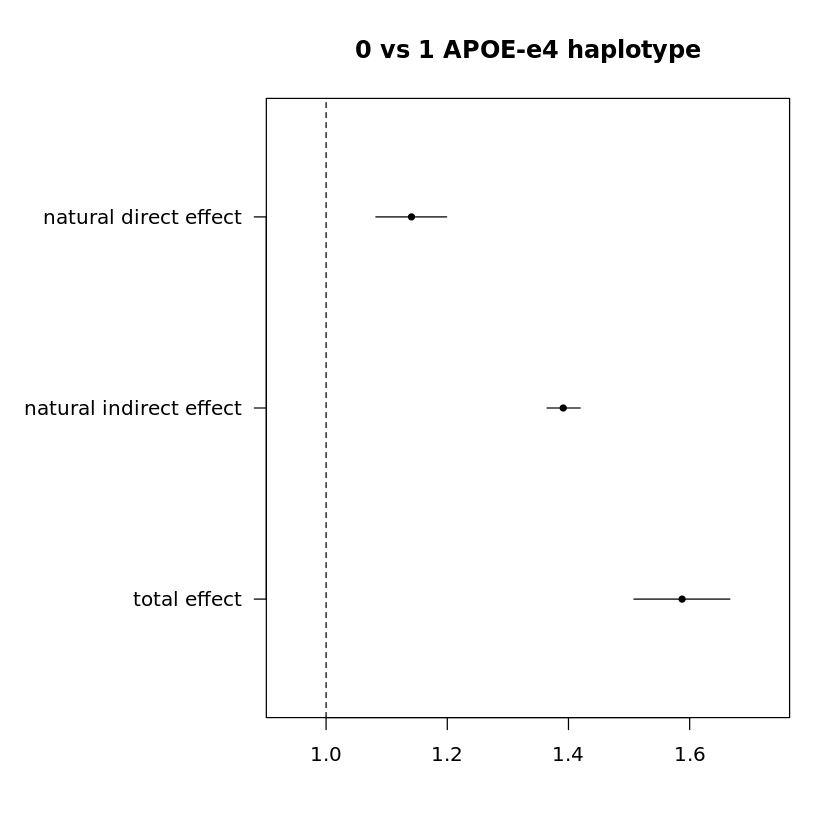

In [105]:
# get total effects
effdecomp_1 <- neEffdecomp(neMod1, xRef = c(0,1))
summary(effdecomp_1)
plot(effdecomp_1, transf = exp, main="0 vs 1 APOE-e4 haplotype")

 effdecomp_2 <- neEffdecomp(neMod1, xRef = c(0,2))
# summary(effdecomp_2)
# plot(effdecomp_2, transf = exp, main="0 vs 2 APOE-e4 haplotype")

#lht <- neLht(neMod1, linfct = c("e4_status01 + e4_status11 = 0", "e4_status02 + e4_status12 = 0"))
#summary(lht)

Saving 6.67 x 6.67 in image


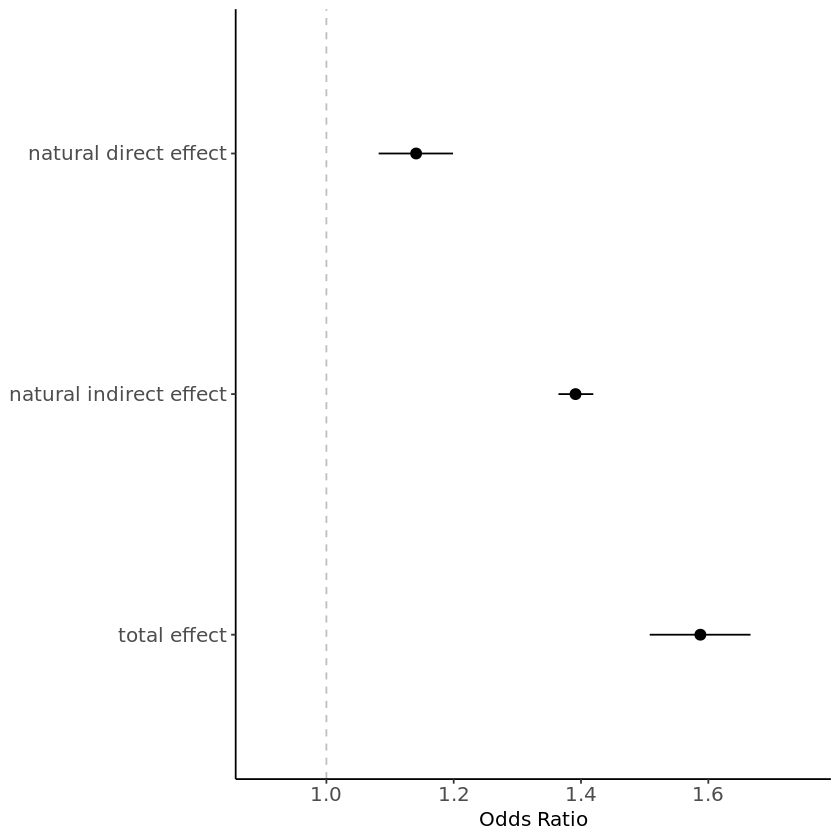

In [140]:
## make custom plot
# prepare data to plot
ed_toplot1 <- 
    summary(effdecomp_1)$coefficients %>% as.data.frame %>%
    merge(., confint(effdecomp_1), by=0) %>%
    mutate('Odds Ratio'=exp(Estimate),
           OR_95LCL = exp(`95% LCL`),
           OR_95UCL = exp(`95% UCL`),
           Effect = factor(Row.names, levels=rev(Row.names)),
           y = Effect
          )
ed_toplot2 <- 
    summary(effdecomp_2)$coefficients %>% as.data.frame %>%
    merge(., confint(effdecomp_2), by=0) %>%
    mutate('Odds Ratio'=exp(Estimate),
           OR_95LCL = exp(`95% LCL`),
           OR_95UCL = exp(`95% UCL`),
           Effect = factor(Row.names, levels=rev(Row.names)),
           y= Effect
          )

ed_toplot <- bind_rows(ed_toplot1, ed_toplot2)
#ed_toplot
# custom plot
ggplot(ed_toplot1, aes(x=`Odds Ratio`, y=Effect, group=Effect)) + 
    geom_pointrange(aes(xmin=OR_95LCL, xmax=OR_95UCL, group=Effect), position=position_dodge(width=0.2))  +
    coord_cartesian(xlim = c(0.9,1.75)) + 
    geom_vline(xintercept = 1, linetype="dashed", col='grey') +
    #eliminates background, gridlines, and chart border
    theme_bw() +
    theme(
        plot.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank()
    ) +
    #draws x and y axis line
    theme(axis.line = element_line(color = 'black')) +
    # remove y axis label
    theme(axis.title.y=element_blank(),
          axis.text=element_text(size=12),
          axis.title.x=element_text(size=12))

ggsave('ne_plot.png', dpi=600)
system('dx upload ne_plot.png --dest vasilis/data/mediation/')

In [39]:
## save model objects
saveRDS(neMod1, 'neMod1.rds')
system('dx upload neMod1.rds --dest vasilis/data/mediation/', intern = T)

[1] "ID                                file-GyFpqK0JZB798pgvkyKyxzB4"   
 [2] "Class                             file"                            
 [3] "Project                           project-GfvP6PQJZB72v2Vk348Bb2yg"
 [4] "Folder                            /vasilis/data/mediation"         
 [5] "Name                              neMod1.rds"                      
 [6] "State                             closing"                         
 [7] "Visibility                        visible"                         
 [8] "Types                             -"                               
 [9] "Properties                        -"                               
[10] "Tags                              -"                               
[11] "Outgoing links                    -"                               
[12] "Created                           Mon Jan 27 16:00:56 2025"        
[13] "Created by                        vasilisraptis"                   
[14] " via the job                      job-GyFbVgjJZB78kkJPK7Y8jVY9"    
[15] "Last modified                     Mon Jan 27 16:00:59 2025"        
[16] "Media type                        "                                
[17] "archivalState                     \"live\""                        
[18] "cloudAccount                      \"cloudaccount-dnanexus\""

In [8]:
# imputation-based method
impFit <- glm(delirium ~ as.factor(e4_status) + dementia_status + age + sex, data = eur_data, family = binomial("logit"))
expData2 <- neImpute(impFit)
#head(expData2)
neMod2 <- neModel(delirium ~ e4_status0 + e4_status1 + age + sex, data = eur_data , family = binomial("logit"), expData = expData, nBoot = 100)
summary(neMod2)

  |======================================================================| 100%

Natural effect model
with standard errors based on the non-parametric bootstrap
---
Exposure: e4_status 
Mediator(s): dementia_status 
---
Parameter estimates:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -10.334334   0.114320 -90.398  < 2e-16 ***
e4_status01   0.131867   0.025821   5.107 3.28e-07 ***
e4_status02   0.255426   0.054205   4.712 2.45e-06 ***
e4_status11   0.330302   0.009990  33.064  < 2e-16 ***
e4_status12   0.953361   0.026001  36.666  < 2e-16 ***
age           0.081572   0.001533  53.215  < 2e-16 ***
sex           0.462844   0.031163  14.853  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

#### *mediation package*

In [41]:
# fit mediator and outcome models
med.fit <- glm(dementia_status ~ e4_status + age + sex, data = eur, family=binomial("logit"))
out.fit <- glm(delirium ~ dementia_status + e4_status + age + sex, data = eur, family=binomial("logit"))

#med.fit <- lm(age ~ sex + PC1, data = eur)
#out.fit <- lm(batch ~ age + sex + PC1, data = eur)

summary(med.fit)
summary(out.fit)


Call:
glm(formula = dementia_status ~ e4_status + age + sex, family = binomial("logit"), 
    data = eur)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -13.717998   0.151736  -90.41   <2e-16 ***
e4_status     1.011107   0.017496   57.79   <2e-16 ***
age           0.125430   0.001966   63.80   <2e-16 ***
sex           0.237197   0.022560   10.51   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 80840  on 407826  degrees of freedom
Residual deviance: 72547  on 407823  degrees of freedom
AIC: 72555

Number of Fisher Scoring iterations: 7



Call:
glm(formula = delirium ~ dementia_status + e4_status + age + 
    sex, family = binomial("logit"), data = eur)

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -7.959315   0.137075 -58.065  < 2e-16 ***
dementia_status  3.376274   0.029494 114.472  < 2e-16 ***
e4_status        0.170144   0.021569   7.888 3.06e-15 ***
age              0.045800   0.001848  24.783  < 2e-16 ***
sex              0.415100   0.024893  16.675  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 74975  on 407826  degrees of freedom
Residual deviance: 61827  on 407822  degrees of freedom
AIC: 61837

Number of Fisher Scoring iterations: 7


In [40]:
# attributes(out.fit)
# # controls
# out.fit$fitted.values[which(eur$delirium==0)] %>% mean
# # cases
# out.fit$fitted.values[which(eur$delirium!=0)] %>% mean


In [42]:
# estimate the ACME and ADE
med.out <- mediate(med.fit, out.fit, 
                   treat = "e4_status", 
                   mediator = "dementia_status",
                   covariates = c('sex', 'age'),
                   robustSE = TRUE, sims = 100)
summary(med.out)


Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

(Inference Conditional on the Covariate Values Specified in `covariates')

                         Estimate 95% CI Lower 95% CI Upper p-value    
ACME (control)            0.00612      0.00577         0.01  <2e-16 ***
ACME (treated)            0.00682      0.00641         0.01  <2e-16 ***
ADE (control)             0.00251      0.00192         0.00  <2e-16 ***
ADE (treated)             0.00321      0.00246         0.00  <2e-16 ***
Total Effect              0.00933      0.00866         0.01  <2e-16 ***
Prop. Mediated (control)  0.65781      0.58773         0.72  <2e-16 ***
Prop. Mediated (treated)  0.73265      0.67443         0.78  <2e-16 ***
ACME (average)            0.00647      0.00609         0.01  <2e-16 ***
ADE (average)             0.00286      0.00220         0.00  <2e-16 ***
Prop. Mediated (average)  0.69523      0.63109         0.75  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


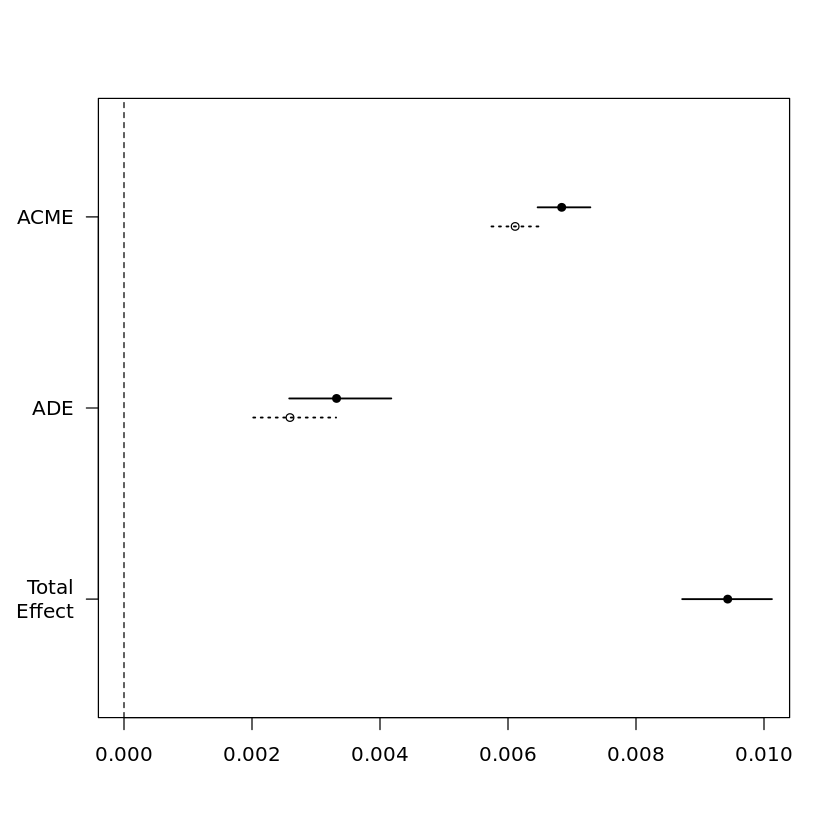

In [28]:
plot(med.out, xlim=c(0,0.01))